In [1]:
# Thêm autoreload vào để tự động reload lại module nếu có thay đổi code trong module
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# Các model scikit learn cho bài toán phân loại
from sklearn.svm import SVC # Support vector machine
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBClassifier
from tqdm import tqdm
import json

import os, sys
sys.path.append(os.path.abspath(".."))
from utils.common import save_model

seed = 42
np.random.seed(seed)

### 1. Các thông tin về dữ liệu

In [2]:
from tqdm import tqdm
from sklearn.base import clone
from sklearn.utils.validation import check_is_fitted

class ProgressWrapper:
    """
    Lớp bao bọc để thêm thanh tiến trình `tqdm` cho quá trình huấn luyện của bất kỳ mô hình nào từ Scikit-learn.
    """
    def __init__(self, model):
        self.model = clone(model)

    def fit(self, X, y, **fit_params):
        # Đếm tổng số cây (estimators) được xây dựng trong RandomForestClassifier
        n_estimators = getattr(self.model, 'n_estimators', 1)

        with tqdm(total=n_estimators, desc="Training", unit="tree") as pbar:
            original_fit = self.model.fit

            def fit_and_update(*args, **kwargs):
                for i in range(n_estimators):
                    original_fit(*args, **kwargs)
                    pbar.update(1)

            self.model.fit = fit_and_update
            try:
                self.model.fit(X, y, **fit_params)
            finally:
                self.model.fit = original_fit
                pbar.close()

        return self

    def predict(self, X):
        check_is_fitted(self.model)
        return self.model.predict(X)

    def predict_proba(self, X):
        check_is_fitted(self.model)
        return self.model.predict_proba(X)

    def score(self, X, y):
        check_is_fitted(self.model)
        return self.model.score(X, y)

    def __getattr__(self, name):
        return getattr(self.model, name)


In [3]:
train_df = pd.read_csv("train_clean.csv")

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2462 entries, 0 to 2461
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   label               2462 non-null   object 
 1   nose_x              2462 non-null   float64
 2   nose_y              2462 non-null   float64
 3   nose_z              2462 non-null   float64
 4   left_shoulder_x     2462 non-null   float64
 5   left_shoulder_y     2462 non-null   float64
 6   left_shoulder_z     2462 non-null   float64
 7   right_shoulder_x    2462 non-null   float64
 8   right_shoulder_y    2462 non-null   float64
 9   right_shoulder_z    2462 non-null   float64
 10  left_hip_x          2462 non-null   float64
 11  left_hip_y          2462 non-null   float64
 12  left_hip_z          2462 non-null   float64
 13  right_hip_x         2462 non-null   float64
 14  right_hip_y         2462 non-null   float64
 15  right_hip_z         2462 non-null   float64
 16  left_k

In [5]:
train_df.columns

Index(['label', 'nose_x', 'nose_y', 'nose_z', 'left_shoulder_x',
       'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x',
       'right_shoulder_y', 'right_shoulder_z', 'left_hip_x', 'left_hip_y',
       'left_hip_z', 'right_hip_x', 'right_hip_y', 'right_hip_z',
       'left_knee_x', 'left_knee_y', 'left_knee_z', 'right_knee_x',
       'right_knee_y', 'right_knee_z', 'left_ankle_x', 'left_ankle_y',
       'left_ankle_z', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z',
       'left_heel_x', 'left_heel_y', 'left_heel_z', 'right_heel_x',
       'right_heel_y', 'right_heel_z', 'left_foot_index_x',
       'left_foot_index_y', 'left_foot_index_z', 'right_foot_index_x',
       'right_foot_index_y', 'right_foot_index_z'],
      dtype='object')

In [6]:
train_df.head()

,label,nose_x,nose_y,nose_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,D,-0.045332,-0.312278,0.025817,-0.003468,-0.236481,-0.137639,-0.004457,-0.237314,0.206035,...,0.029322,0.153061,0.134413,0.058777,-0.116457,0.233184,0.018748,0.134836,0.208726,0.050868
1,D,-0.036876,-0.316079,0.025362,0.002906,-0.249338,-0.161753,0.003340,-0.246322,0.212587,...,-0.180082,-0.070181,0.250603,0.154884,0.111356,0.274413,-0.231801,-0.121906,0.248574,0.139393
2,D,-0.042562,-0.311502,-0.002624,-0.000249,-0.237705,-0.156688,0.003185,-0.235856,0.168590,...,-0.050998,0.025495,0.195137,0.079456,0.044727,0.245372,-0.071741,0.005740,0.234293,0.069344
3,D,-0.043028,-0.309828,-0.012327,-0.003478,-0.232540,-0.164551,-0.006258,-0.231792,0.172023,...,-0.007732,0.168087,0.131500,0.049326,-0.100497,0.227354,-0.007181,0.144870,0.205615,0.041901
4,D,-0.035741,-0.315002,0.014858,0.005436,-0.248575,-0.154430,0.002749,-0.244614,0.200926,...,-0.049212,0.066569,0.230884,0.072321,-0.079495,0.282712,-0.086518,0.044977,0.273339,0.059026


### 2. Training model

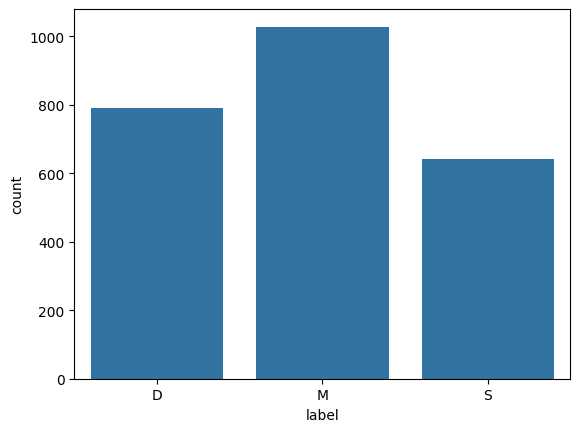

In [7]:
sns.countplot(x="label", data=train_df);

In [8]:
# Chuyển dữ liệu của label về dạng số
from sklearn.preprocessing import LabelEncoder

# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()
train_df["label"] = label_encoder.fit_transform(train_df["label"])

In [9]:
# Extract features
X_train = train_df.drop(columns="label")
y_train = train_df["label"]

In [10]:
X_train.head()

,nose_x,nose_y,nose_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,left_hip_x,...,left_heel_z,right_heel_x,right_heel_y,right_heel_z,left_foot_index_x,left_foot_index_y,left_foot_index_z,right_foot_index_x,right_foot_index_y,right_foot_index_z
0,-0.045332,-0.312278,0.025817,-0.003468,-0.236481,-0.137639,-0.004457,-0.237314,0.206035,-0.002482,...,0.029322,0.153061,0.134413,0.058777,-0.116457,0.233184,0.018748,0.134836,0.208726,0.050868
1,-0.036876,-0.316079,0.025362,0.002906,-0.249338,-0.161753,0.003340,-0.246322,0.212587,0.000023,...,-0.180082,-0.070181,0.250603,0.154884,0.111356,0.274413,-0.231801,-0.121906,0.248574,0.139393
2,-0.042562,-0.311502,-0.002624,-0.000249,-0.237705,-0.156688,0.003185,-0.235856,0.168590,-0.002056,...,-0.050998,0.025495,0.195137,0.079456,0.044727,0.245372,-0.071741,0.005740,0.234293,0.069344
3,-0.043028,-0.309828,-0.012327,-0.003478,-0.232540,-0.164551,-0.006258,-0.231792,0.172023,-0.002649,...,-0.007732,0.168087,0.131500,0.049326,-0.100497,0.227354,-0.007181,0.144870,0.205615,0.041901
4,-0.035741,-0.315002,0.014858,0.005436,-0.248575,-0.154430,0.002749,-0.244614,0.200926,-0.000541,...,-0.049212,0.066569,0.230884,0.072321,-0.079495,0.282712,-0.086518,0.044977,0.273339,0.059026


In [11]:
y_train

0       0
1       0
2       0
3       0
4       0
       ..
2457    2
2458    2
2459    2
2460    2
2461    2
Name: label, Length: 2462, dtype: int32

In [12]:
# Chuẩn hoá dữ liệu trên tập huấn luyện bằng z-scores
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [13]:
# X lúc này là một DataFrame mới với các cột mới được đánh số từ 0 đến n-1, trong đó n là số lượng cột trong dữ liệu ban đầu
X_train

array([[-1.05462959, -1.5594792 ,  0.80133167, ...,  1.7604695 ,
        -0.29259991, -0.14771675],
       [-0.85783309, -1.63734362,  0.79809546, ..., -1.45253146,
         0.30242334,  0.28524061],
       [-0.99016512, -1.54358427,  0.59895008, ...,  0.14490419,
         0.08917332, -0.05735456],
       ...,
       [-0.85483926, -0.12923864,  0.13087295, ..., -0.02081609,
         0.26551636,  0.54916156],
       [-0.72163738,  0.0886837 ,  0.19389094, ..., -0.09776255,
         0.28988901,  0.36976653],
       [-0.81320726,  0.30453798,  0.23499636, ..., -0.04278129,
         0.3283313 ,  0.36840566]])

In [14]:
import warnings
warnings.filterwarnings("ignore")

k_fold = KFold(n_splits=5, random_state=seed, shuffle=True)

In [15]:
def evaluate_model(name, model, results):
    # Đánh giá Model
    accuracy = cross_val_score(
        model, X_train, y_train, cv=k_fold, scoring="accuracy", n_jobs=-1, verbose=1
    ).mean()

    f1_score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring="f1_macro").mean()
    results.append((name, accuracy, f1_score))

In [16]:
algorithms = [
    ("LR", LogisticRegression(random_state=seed)),
    ("SVC", SVC(probability=True, random_state=seed)),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed)),
    ("RF", RandomForestClassifier(random_state=seed)),
    ("XGB", XGBClassifier(random_state=seed)),
]

models = {}
results_before_tunning = []

for name, model in algorithms:
    trained_model = model.fit(X_train, y_train)
    models[name] = trained_model
    evaluate_model(name, model, results_before_tunning)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished


In [17]:
def print_results(results):
    results.sort(key=lambda el: el[2], reverse=True)

    return pd.DataFrame(
        results,
        columns=[
            "Model",
            "Accuracy score",
            "F1 score",
        ],
    )

print_results(results_before_tunning)

,Model,Accuracy score,F1 score
0,XGB,0.938267,0.940796
1,RF,0.935837,0.938857
2,SVC,0.918364,0.920616
3,KNN,0.914304,0.917103
4,LR,0.905370,0.906911
5,DTC,0.889930,0.893786


### Điều chỉnh siêu tham số cho các model

In [19]:
from sklearn.model_selection import RandomizedSearchCV

results_after_tuning = []

##### 1.1. Điều chỉnh siêu tham số cho Random Forest

In [19]:
random_forest = models["RF"]

  # Định nghĩa phạm vi của các siêu tham số cần tối ưu
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_features': ['log2', 'sqrt'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Tạo RandomizedSearchCV
random_search = RandomizedSearchCV(estimator = random_forest, param_distributions = param_grid,
                                n_iter = 100, cv = k_fold, verbose=3, random_state=seed, n_jobs = -1)

# Tiến hành tìm kiếm siêu tham số
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, None],
                                        'max_features': ['log2', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300, 400,
                                                         500]},
                   random_state=42, verbose=3)

In [20]:
random_search.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [21]:
json.dump(random_search.best_params_, open("./hyper_parameter/random_forest.json", "w"))

##### 1.2. Kiểm tra sự cải thiện của độ chính xác sau khi điều chỉnh siêu tham số cho Random Forest

In [20]:
with open('./hyper_parameter/random_forest.json', 'r') as f:
    best_params = json.load(f)
    best_params["bootstrap"] = bool(best_params["bootstrap"])

# Khởi tạo một mô hình Random Forest mới với các tham số tối ưu
best_random_forest_model = RandomForestClassifier(**best_params, random_state=seed, verbose=1)
best_random_forest_model.fit(X_train, y_train)

# Huấn luyện mô hình mới với dữ liệu huấn luyện của bạn
result = []
evaluate_model("RF", best_random_forest_model, result)
results_after_tuning.append(result[0])
print_results(result)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s

,Model,Accuracy score,F1 score
0,RF,0.938269,0.940898


##### 2.1. Điều chỉnh siêu tham số cho SVC

In [23]:
from sklearn.model_selection import GridSearchCV

svc_model = models["SVC"]

param_grid = {
    "C": [0.1, 1, 10, 100],
    "gamma": [0.001, 0.01, 0.1, 1],
    "kernel": ["linear", "rbf", "poly", "sigmoid"],
}

# Tạo GridSearchCV instance
svc_best_model = GridSearchCV(svc_model, param_grid, cv=5, verbose=3, n_jobs=-1)

# Tiến hành tinh chỉnh siêu tham số trên mô hình đã huấn luyện
svc_best_model.fit(X_train, y_train)

# In ra các siêu tham số tốt nhất được tìm thấy
print("Best Parameters:", svc_best_model.best_params_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


In [24]:
json.dump(svc_best_model.best_params_, open("./hyper_parameter/SVC.json", "w"))

##### Kiểm tra sự cải thiện của độ chính xác sau khi điều chỉnh siêu tham số cho SVC

In [21]:
best_params = json.load(open("./hyper_parameter/SVC.json", "r"))
svc_best_model = SVC(**best_params, random_state=seed)
svc_best_model.fit(X_train, y_train)

SVC(C=100, gamma=0.001, random_state=42)

In [22]:
results = []
evaluate_model("SVC", svc_best_model, results)
results_after_tuning.append(results[0])
print_results(results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


,Model,Accuracy score,F1 score
0,SVC,0.916738,0.918653


In [27]:
save_model(svc_best_model, "./best_models/SVC_model.pkl")

##### 3.1. Điều chỉnh siêu tham số cho các thuật toán còn lại

In [28]:
best_params_random_other = {}
models_tuned_random_other = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("LR", LogisticRegression(random_state=seed)),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed)),
]

# Define parameter grid with correct keys
param_grid = {
    "LR": {
        "C": np.logspace(-4, 4, 20),  # More granular range for C
        "solver": ["liblinear", "lbfgs", "saga", "newton-cg"],  # Added 'newton-cg'
        "penalty": [
            "l1",
            "l2",
            "elasticnet",
            "none",
        ],  # Different norms for regularization
        "class_weight": ["balanced"],  # Added class_weight
    },
    "DTC": {
        "max_depth": [None, 3, 5, 10, 15, 20, 30, 50, 100],  # Expanded range
        "min_samples_split": [2, 5, 10, 20, 40, 100],  # More options
        "min_samples_leaf": [1, 2, 5, 10, 20],  # Added min_samples_leaf
        "class_weight": ["balanced"],
    },
    "KNN": {
        "n_neighbors": list(range(1, 21)),  # More neighbors
        "weights": ["uniform", "distance"],  # Existing weights
        "metric": [
            "euclidean",
            "manhattan",
            "chebyshev",
            "minkowski",
        ], 
    },
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid[name],
            n_iter=100,  # You can adjust the number of iterations
            cv=k_fold,
            scoring="accuracy",
            random_state=seed,
            n_jobs=-1,
            verbose=1,
        )
        randomized_search.fit(X_train, y_train)
        best_params_random_other[name] = randomized_search.best_params_
        models_tuned_random_other[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")

Model processing:  LR
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model processing:  KNN
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Model processing:  DTC
Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [29]:
with open("hyper_parameter/other_algorithms.json", "w") as f:
    json.dump(best_params_random_other, f)

In [25]:
with open("hyper_parameter/other_algorithms.json", "r") as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=42)),
    ("KNN", KNeighborsClassifier(**best_params.get("KNN", {}))),
    ("DTC", DecisionTreeClassifier(**best_params.get("DTC", {}), random_state=42)),
]

for name, model in algorithms:
    result = [] 
    evaluate_model(name, model, result)
    results_after_tuning.append(result[0])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


#### Kết quả trước và sau khi điều chỉnh siêu tham số

In [23]:
print_results(results_before_tunning)

,Model,Accuracy score,F1 score
0,XGB,0.938267,0.940796
1,RF,0.935837,0.938857
2,SVC,0.918364,0.920616
3,KNN,0.914304,0.917103
4,LR,0.905370,0.906911
5,DTC,0.889930,0.893786


In [26]:
print_results(results_after_tuning)

,Model,Accuracy score,F1 score
0,RF,0.938269,0.940898
1,KNN,0.924868,0.927566
2,SVC,0.916738,0.918653
3,LR,0.906994,0.908568
4,DTC,0.892382,0.896224


### Confusion matrix:

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict

In [28]:
with open('./hyper_parameter/random_forest.json', 'r') as f:
    best_params = json.load(f)
    best_params["bootstrap"] = bool(best_params["bootstrap"])

rf_best_model = RandomForestClassifier(**best_params, random_state=seed)
rf_best_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, max_depth=50, min_samples_leaf=2,
                       n_estimators=400, random_state=42)

In [29]:
y_pred = rf_best_model.predict(X_train)
cm_full_train = confusion_matrix(y_train, y_pred)
accuracy = accuracy_score(y_train, y_pred)
cm_full_train, accuracy

(array([[ 792,    0,    0],
        [   0, 1028,    0],
        [   0,    0,  642]], dtype=int64),
 1.0)

In [30]:
accuracy = cross_val_score(rf_best_model, X_train, y_train, cv=k_fold, scoring="accuracy").mean()
y_pred = cross_val_predict(rf_best_model, X_train, y_train, cv=k_fold)
cm_cross_val = confusion_matrix(y_train, y_pred)
accuracy, cm_cross_val

(0.9382691007437458,
 array([[742,  50,   0],
        [ 54, 947,  27],
        [  0,  21, 621]], dtype=int64))

<Axes: >

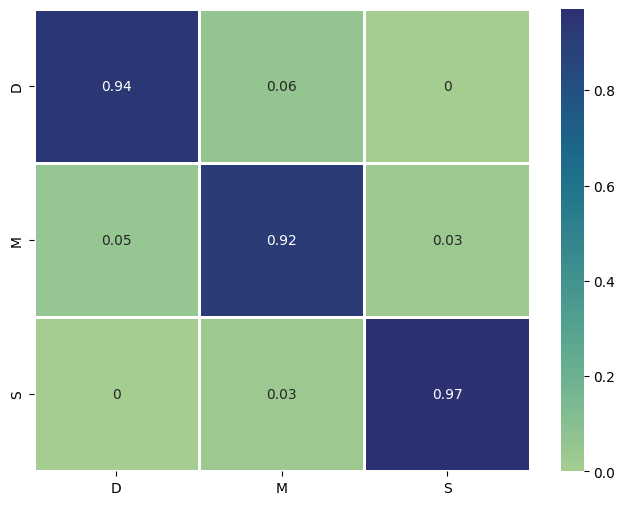

In [31]:
label_counts = np.sum(cm_cross_val, axis=1)
cm_cross_val = cm_cross_val / label_counts[:, None]
cm_cross_val = np.round(cm_cross_val, 2)
confusion_matrix_df = pd.DataFrame(cm_cross_val, index=["D", "M", "S"], columns=["D", "M", "S"])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, linewidths=1, annot=True, ax=ax, fmt="g", cmap="crest")

#### Lưu lại model

In [38]:
save_model(scaler, "./best_models/input_scaler.pkl")
save_model(rf_best_model, "./best_models/RF_model.pkl")